<a href="https://colab.research.google.com/github/devansh404/Projects/blob/main/Fraudulent_Truck_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection of Fraudulent Truck Drivers Using GPS Telemetry Data**

*Devansh Chopra*

## Problem Statement

In the logistics and transportation industry, the misuse or fraudulent use of transport vehicles results in substantial financial losses, delivery delays, and reputational harm. Such frauds may include unauthorized vehicle movement, GPS spoofing, tampering with onboard systems, or running vehicles without proper authorization.

The objective of this project is to develop a data-driven solution to detect potentially fraudulent trucks using real-time GPS telemetry data. By analyzing parameters such as vehicle speed, location, GPS fix status, satellite visibility, and ignition state, the system aims to flag suspicious behavior and help transport authorities or fleet managers take timely corrective actions.

## Literature Review

### **A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise**

*Martin Ester, Hans-Peter Kriegel, Jörg Sander, Xiaowei Xu*

The paper by Ester et al. (1996) introduces DBSCAN, a density-based clustering algorithm designed for large spatial databases. It identifies clusters as regions of high data point density separated by areas of low density, requiring only two input parameters: the neighborhood radius (Eps) and the minimum number of points (MinPts) to form a dense region. DBSCAN's major advantages include its ability to discover clusters of arbitrary shape, its robustness in handling noise, and its efficiency on large datasets. This makes it particularly suitable for applications like fraudulent truck detection, where GPS data may contain irregularities, outliers, or noise. In such cases, DBSCAN can effectively reveal anomalous patterns, such as isolated location reports or unusual movement behaviors, without the need to predefine the number of clusters—an essential feature when dealing with unpredictable and real-world vehicle tracking data.

### **ST-DBSCAN: An algorithm for clustering spatial–temporal data** [Link](https://www.sciencedirect.com/science/article/pii/S0169023X06000218)
*Derya Birant, Alp Kut*

The paper by Birant and Kut (2007) introduces ST-DBSCAN, an extension of the DBSCAN algorithm specifically designed for clustering spatio-temporal data. Unlike traditional DBSCAN, which focuses solely on spatial proximity, ST-DBSCAN incorporates two distance thresholds: one for spatial distance (Eps1) and another for temporal distance (Eps2). This enhancement allows the algorithm to identify clusters that are close in both location and time, making it well-suited for analyzing movement data. Additionally, the authors introduce a density factor to effectively handle clusters of varying densities. For projects involving GPS-based vehicle tracking, such as fraudulent truck detection, ST-DBSCAN offers a significant advantage by enabling the detection of abnormal behaviors like trucks making unauthorized stops, moving during unusual hours, or reporting inconsistent data over time. By considering both spatial and temporal aspects, ST-DBSCAN provides a more realistic and powerful clustering approach for identifying patterns in real-world trajectory data.


### **A Hierarchical ST-DBSCAN with Three Neighborhood Boundary Clustering Algorithm for Clustering Spatio–temporal Data**
*Amalia Mabrina Masbar Rus, Zulaiha Ali Othman, Azuraliza Abu Bakar, Suhaila Zainudin*

The paper by Masbar et al. (2022) presents an improved version of the ST-DBSCAN algorithm tailored for clustering complex spatio-temporal data. The proposed method introduces three distinct neighborhood boundaries—spatial, non-spatial, and temporal—which allows the algorithm to consider multiple dimensions of proximity when grouping data. Additionally, it incorporates a hierarchical clustering approach using Ward's method to further refine cluster quality and reduce noise. This enhanced algorithm demonstrated a significant improvement in clustering performance, achieving up to 73% better accuracy on the El Niño dataset. For a project focused on fraudulent truck detection, this approach is particularly relevant, as it enables the integration of not just spatial and temporal data, but also sensor-related parameters such as satellite visibility or GSM signal strength. The combination of tri-dimensional clustering with hierarchical refinement makes this technique highly effective for detecting complex anomalies in real-world movement patterns and sensor-based datasets.

## Installations and Imports

In [1]:
!pip install haversine
import json
import numpy as np
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import defaultdict
import plotly.express as px
from haversine import haversine
from datetime import timedelta
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## Data Cleaning and Preprocessing

In [2]:
with open('merged.json', 'r') as file:
    raw_data = json.load(file)
data = raw_data[0] if isinstance(raw_data, list) else raw_data

In [3]:
flat_rows = []
for data in raw_data:
    for entry in data.get("responseData", []):
        vehicle_number = entry.get("vehicleNumber")
        time_bucket = entry.get("timeBucketStartTime")

        for loc in entry.get("locationDeviceTimeMap", []):
            row = {
                "statusCode": data.get("statusCode"),
                "statusMessage": data.get("statusMessage"),
                "vehicleNumber": vehicle_number,
                "timeBucketStartTime": time_bucket,
                **{k: v for k, v in loc.items() if k != "point"}
            }

            point = loc.get("point", {})
            coords = point.get("coordinates", {})
            row["coordinates.x"] = coords.get("x")
            row["coordinates.y"] = coords.get("y")
            row["point.type"] = point.get("type")
            row["boundingBox"] = point.get("boundingBox")
            row["coordinateReferenceSystem"] = point.get("coordinateReferenceSystem")
            row["extraMembers"] = point.get("extraMembers")

            flat_rows.append(row)

given_df = pd.DataFrame(flat_rows)

# Preview
print(f" Total rows: {len(given_df)}")
print(f"Unique vehicles: {given_df['vehicleNumber'].nunique()}")
given_df

 Total rows: 168394
Unique vehicles: 43


statusCode                                      statusMessage  \
0             200  Found Data in GetVehicleTrackingData action wi...   
1             200  Found Data in GetVehicleTrackingData action wi...   
2             200  Found Data in GetVehicleTrackingData action wi...   
3             200  Found Data in GetVehicleTrackingData action wi...   
4             200  Found Data in GetVehicleTrackingData action wi...   
...           ...                                                ...   
168389        200  Found Data in GetVehicleTrackingData action wi...   
168390        200  Found Data in GetVehicleTrackingData action wi...   
168391        200  Found Data in GetVehicleTrackingData action wi...   
168392        200  Found Data in GetVehicleTrackingData action wi...   
168393        200  Found Data in GetVehicleTrackingData action wi...   

       vehicleNumber        timeBucketStartTime         deviceId  \
0         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
1         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
2         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
3         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
4         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
...              ...                        ...              ...   
168389    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168390    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168391    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168392    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168393    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   

                             date                    createdDate     latitude  \
0       2025-05-14T17:02:52+05:30  2025-05-14T17:03:44.439+05:30  21.66272333   
1       2025-05-14T17:04:52+05:30  2025-05-14T17:05:46.565+05:30  21.66272333   
2       2025-05-14T17:06:52+05:30  2025-05-14T17:07:46.351+05:30  21.66272333   
3       2025-05-14T17:10:52+05:30  2025-05-14T17:11:44.601+05:30  21.66272333   
4       2025-05-14T17:13:52+05:30  2025-05-14T17:14:46.769+05:30  21.66272333   
...                           ...                            ...          ...   
168389  2025-05-09T17:43:28+05:30  2025-05-09T17:43:50.036+05:30  19.74624167   
168390  2025-05-09T17:45:28+05:30  2025-05-09T17:45:48.755+05:30  19.74624167   
168391  2025-05-09T17:48:28+05:30  2025-05-09T17:48:47.308+05:30  19.74624167   
168392  2025-05-09T17:53:28+05:30  2025-05-09T17:54:00.406+05:30  19.74624167   
168393  2025-05-09T17:56:28+05:30    2025-05-09T17:56:30.7+05:30  19.74624167   

          longitude  speed  ...  ccidNumber  externalBatteryVoltage  rpmValue  \
0          81.74063      0  ...           0                     0.0         0   
1          81.74063      0  ...           0                     0.0         0   
2          81.74063      0  ...           0                     0.0         0   
3          81.74063      0  ...           0                     0.0         0   
4          81.74063      0  ...           0                     0.0         0   
...             ...    ...  ...         ...                     ...       ...   
168389  72.71081167      0  ...           0                     0.0         0   
168390  72.71081167      0  ...           0                     0.0         0   
168391  72.71081167      0  ...           0                     0.0         0   
168392  72.71081167      0  ...           0                     0.0         0   
168393  72.71081167      0  ...           0                     0.0         0   

        unloadTrip  coordinates.x  coordinates.y  point.type  boundingBox  \
0                0      81.740630      21.662723           7         None   
1                0      81.740630      21.662723           7         None   
2                0      81.740630      21.662723           7         None   
3                0      81.740630      21.662723           7         No

In [4]:
given_df.drop(columns=['odometer', 'deviceCompanyId', 'dI2Status', 'dI3Status', 'aI1', 'reserved', 'internalBatteryVoltage', 'firmwareVersion', 'ccidNumber', 'externalBatteryVoltage', 'rpmValue', 'unloadTrip', 'powercut', 'invoiceNo', 'boxOpen', 'ignition', 'vehicleStatusId', 'point.type', 'boundingBox', 'coordinateReferenceSystem', 'extraMembers', 'statusCode', 'statusMessage'], inplace = True)

given_df

vehicleNumber        timeBucketStartTime         deviceId  \
0         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
1         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
2         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
3         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
4         MH48CQ8407  2025-05-14T17:00:00+05:30  862491072285032   
...              ...                        ...              ...   
168389    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168390    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168391    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168392    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   
168393    CG04LZ8949  2025-05-09T17:00:00+05:30  860187062211689   

                             date                    createdDate     latitude  \
0       2025-05-14T17:02:52+05:30  2025-05-14T17:03:44.439+05:30  21.66272333   
1       2025-05-14T17:04:52+05:30  2025-05-14T17:05:46.565+05:30  21.66272333   
2       2025-05-14T17:06:52+05:30  2025-05-14T17:07:46.351+05:30  21.66272333   
3       2025-05-14T17:10:52+05:30  2025-05-14T17:11:44.601+05:30  21.66272333   
4       2025-05-14T17:13:52+05:30  2025-05-14T17:14:46.769+05:30  21.66272333   
...                           ...                            ...          ...   
168389  2025-05-09T17:43:28+05:30  2025-05-09T17:43:50.036+05:30  19.74624167   
168390  2025-05-09T17:45:28+05:30  2025-05-09T17:45:48.755+05:30  19.74624167   
168391  2025-05-09T17:48:28+05:30  2025-05-09T17:48:47.308+05:30  19.74624167   
168392  2025-05-09T17:53:28+05:30  2025-05-09T17:54:00.406+05:30  19.74624167   
168393  2025-05-09T17:56:28+05:30    2025-05-09T17:56:30.7+05:30  19.74624167   

          longitude  speed  direction  satVisible  gsmStrength  altitude  \
0          81.74063      0        140          18           25       272   
1          81.74063      0        140          17           26       272   
2          81.74063      0         73          19           27       272   
3          81.74063      0         73          19           22       272   
4          81.74063      0         73          17           28       272   
...             ...    ...        ...         ...          ...       ...   
168389  72.71081167      0        220          18           27         9   
168390  72.71081167      0        238          19           25         9   
168391  72.71081167      0        243          19           25         9   
168392  72.71081167      0        281          20           23         9   
168393  72.71081167      0        229          19           25         9   

        coordinates.x  coordinates.y  
0           81.740630      21.662723  
1           81.740630      21.662723  
2           81.740630      21.662723  
3           81.740630      21.662723  
4           81.740630      21.662723  
...               ...            ...  
168389      72.710812      19.746242  
168390      72.710812      19.746242  
168391      72.710812      19.746242  
168392      72.710812      19.746242  
168393      72.710812      19.746242  

[168394 rows x 14 columns]

In [5]:
given_df = given_df[given_df['speed']!=0]
given_df['date'] = pd.to_datetime(given_df['date'])

deviceId_map = {deviceId: i+1 for i, deviceId in enumerate(given_df['deviceId'].unique())}
given_df['Truck'] = given_df['deviceId'].map(deviceId_map)

/tmp/ipython-input-5-34287792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  given_df['date'] = pd.to_datetime(given_df['date'])
/tmp/ipython-input-5-34287792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  given_df['Truck'] = given_df['deviceId'].map(deviceId_map)


In [6]:
df = given_df[['Truck', 'date', 'coordinates.x', 'coordinates.y']]
df.rename(columns = {'date': 'DateTime', 'coordinates.x': 'Longitude','coordinates.y': 'Latitude'}, inplace = True)
df

/tmp/ipython-input-6-1862025542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'date': 'DateTime', 'coordinates.x': 'Longitude','coordinates.y': 'Latitude'}, inplace = True)


Truck                  DateTime  Longitude   Latitude
23          1 2025-05-14 16:13:52+05:30  81.784478  21.719545
24          1 2025-05-14 16:12:52+05:30  81.787857  21.726282
25          1 2025-05-14 16:11:52+05:30  81.790513  21.733345
26          1 2025-05-14 16:14:52+05:30  81.780485  21.713140
27          1 2025-05-14 16:15:52+05:30  81.775925  21.706322
...       ...                       ...        ...        ...
168207     14 2025-05-10 04:44:29+05:30  72.735012  19.786837
168209     14 2025-05-10 04:52:29+05:30  72.741480  19.785328
168210     14 2025-05-10 04:54:29+05:30  72.748630  19.785403
168211     14 2025-05-10 04:55:42+05:30  72.752485  19.785697
168212     14 2025-05-10 04:59:29+05:30  72.761603  19.786617

[143990 rows x 4 columns]

## Visualisation


/tmp/ipython-input-7-287279685.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_rainbow', len(trucks))
/tmp/ipython-input-7-287279685.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


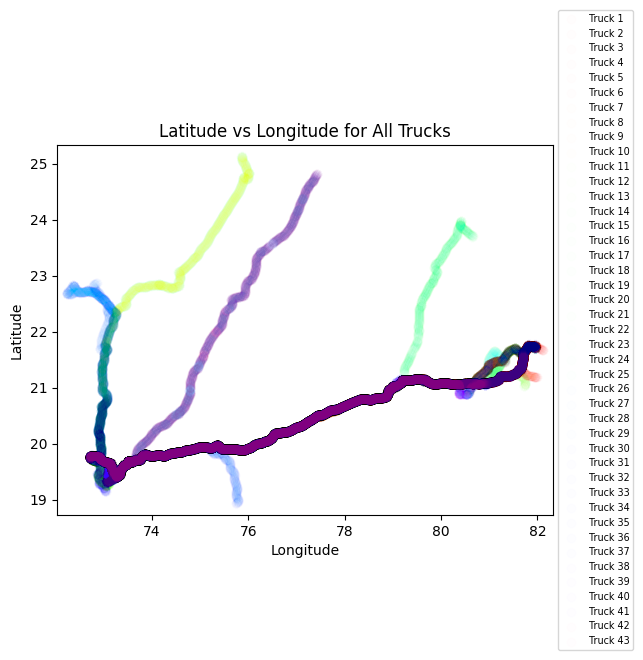

In [7]:
trucks = df['Truck'].unique()

# Create color map
cmap = cm.get_cmap('gist_rainbow', len(trucks))
# 'hsv', 'nipy_spectral', 'gist_rainbow'

# Plot each truck
for i, truck in enumerate(trucks):
    truck_data = df[df['Truck'] == truck]
    plt.scatter(
        truck_data['Longitude'],
        truck_data['Latitude'],
        label=f'Truck {truck}',
        c=cmap(i),
        alpha=0.0075
    )

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude vs Longitude for All Trucks')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),  # Push legend outside
    fontsize='x-small'
)

# Auto-adjust x and y limits
plt.xlim(df['Longitude'].min() - 0.2, df['Longitude'].max() + 0.2)
plt.ylim(df['Latitude'].min() - 0.2, df['Latitude'].max() + 0.2)

plt.show()

In [8]:
fig = px.scatter(
    df,
    x='Longitude',
    y='Latitude',
    color='Truck', # Auto-color by Truck
    hover_data=['DateTime'],
    title='Truck Positions by Color'
)

fig.show()

In [12]:
time_start = []
time_end = []

for i, truck in enumerate(df['Truck'].unique()):
    truck_data = df['DateTime'][df['Truck'] == truck]
    time_start.append(abs(truck_data.iloc[1] - truck_data.iloc[0]).total_seconds())
    time_end.append(abs(truck_data.iloc[-1] - truck_data.iloc[-2]).total_seconds())

    #print(f"Truck {truck}: gps period {time_start[i]} or {time_end[i]}")

print(f'median: {stats.median(time_start)} and mode: {stats.mode(time_start)}')
print(f'estimated mean: {(3*stats.median(time_start) - stats.mode(time_start))/2}')
print(f'actual mean: {stats.mean(time_start)}')
print(f'median: {stats.median(time_end)} and mode: {stats.mode(time_end)}')
print(f'estimated mean: {(3*stats.median(time_end) - stats.mode(time_end))/2}')
print(f'actual mean: {stats.mean(time_end)}')

median: 50.0 and mode: 30.0
estimated mean: 60.0
actual mean: 1182.8372093023256
median: 72.0 and mode: 60.0
estimated mean: 78.0
actual mean: 641.2558139534884


In [13]:
distance_start = []
distance_end = []

for i, truck in enumerate(df['Truck'].unique()):
    truck_data = df[['Latitude', 'Longitude']][df['Truck'] == truck]
    distance_start.append(haversine((truck_data.iloc[0]['Latitude'], truck_data.iloc[0]['Longitude']), (truck_data.iloc[1]['Latitude'], truck_data.iloc[1]['Longitude'])))
    distance_end.append(haversine((truck_data.iloc[-1]['Latitude'], truck_data.iloc[-1]['Longitude']), (truck_data.iloc[-2]['Latitude'], truck_data.iloc[-2]['Longitude'])))

    #print(f"Truck {truck}: period distance {distance_start[i]} or {distance_end[i]}")

print(f'median: {stats.median(distance_start)} and mode: {stats.mode(distance_start)}')
print(f'estimated mean: {(3*stats.median(distance_start) - stats.mode(distance_start))/2}')
print(f'actual mean: {stats.mean(distance_start)}')
print(f'median: {stats.median(distance_end)} and mode: {stats.mode(distance_end)}')
print(f'estimated mean: {(3*stats.median(distance_end) - stats.mode(distance_end))/2}')
print(f'actual mean: {stats.mean(distance_end)}')

median: 0.4173244557720893 and mode: 0.8263854982561496
estimated mean: 0.21279393453005924
actual mean: 0.9309511557287257
median: 0.3893982633121616 and mode: 0.535310605008043
estimated mean: 0.31644209246422095
actual mean: 0.8761281260699211


## Model Implementation

In [14]:
def ST_DBSCAN(df, spatial_threshold, temporal_threshold, min_neighbors):
    cluster_label = 0
    NOISE = -1
    UNMARKED = 777777
    stack = []

    # initialize each point with unmarked
    df['cluster'] = UNMARKED

    # for each point in database
    for index, point in df.iterrows():
        if df.at[index, 'cluster'] == UNMARKED:
            neighborhood = retrieve_neighbors(index, df, spatial_threshold, temporal_threshold)

            if len(neighborhood) < min_neighbors:
                df.at[index, 'cluster'] = NOISE

            else: # found a core point
                cluster_label = cluster_label + 1
                df.at[index, 'cluster'] = cluster_label# assign a label to core point

                for neig_index in neighborhood: # assign core's label to its neighborhood
                    df.at[neig_index, 'cluster'] = cluster_label
                    stack.append(neig_index) # append neighborhood to stack

                while len(stack) > 0: # find new neighbors from core point neighborhood
                    current_point_index = stack.pop()
                    new_neighborhood = retrieve_neighbors(current_point_index, df, spatial_threshold, temporal_threshold)

                    if len(new_neighborhood) >= min_neighbors: # current_point is a new core
                        for neig_index in new_neighborhood:
                            neig_cluster = df.at[neig_index, 'cluster']
                            if (neig_cluster != NOISE) & (neig_cluster == UNMARKED):
                                # TODO: verify cluster average before add new point
                                df.at[neig_index, 'cluster'] = cluster_label
                                stack.append(neig_index)
    return df

def retrieve_neighbors(index_center, df, spatial_threshold, temporal_threshold):
    neigborhood = []

    center_point = df.loc[index_center]

    # filter by time
    min_time = center_point['DateTime'] - timedelta(minutes = temporal_threshold)
    max_time = center_point['DateTime'] + timedelta(minutes = temporal_threshold)
    df = df[(df['DateTime'] >= min_time) & (df['DateTime'] <= max_time)]

    # filter by distance
    for index, point in df.iterrows():
        if index != index_center:
            distance = haversine((center_point['Latitude'], center_point['Longitude']), (point['Latitude'], point['Longitude']))
            if distance <= spatial_threshold:
                neigborhood.append(index)

    return neigborhood

In [15]:
temporal_threshold = 1.25 # time difference between trucks at same location should be less than 2.5 minute
spatial_threshold = 0.35  # distance between trucks should be less than 700m
min_neighbors = 5         # min. no. of gps points of trucks in that neighbourhood -> core point

ST_DBSCAN(df, spatial_threshold, temporal_threshold, min_neighbors)

/tmp/ipython-input-14-955433856.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Truck                  DateTime  Longitude   Latitude  cluster
23          1 2025-05-14 16:13:52+05:30  81.784478  21.719545       -1
24          1 2025-05-14 16:12:52+05:30  81.787857  21.726282       -1
25          1 2025-05-14 16:11:52+05:30  81.790513  21.733345       -1
26          1 2025-05-14 16:14:52+05:30  81.780485  21.713140       -1
27          1 2025-05-14 16:15:52+05:30  81.775925  21.706322       -1
...       ...                       ...        ...        ...      ...
168207     14 2025-05-10 04:44:29+05:30  72.735012  19.786837       -1
168209     14 2025-05-10 04:52:29+05:30  72.741480  19.785328       -1
168210     14 2025-05-10 04:54:29+05:30  72.748630  19.785403       -1
168211     14 2025-05-10 04:55:42+05:30  72.752485  19.785697       -1
168212     14 2025-05-10 04:59:29+05:30  72.761603  19.786617       -1

[143990 rows x 5 columns]

In [21]:
print('Noise:', len(df[df['cluster']==-1]))
print(f'Clusters:', len(df['cluster'].unique())-1)

Noise: 140477
Clusters: 360


In [18]:
multi_truck_clusters = dict(df.groupby('cluster')['Truck'].unique())

normalized = defaultdict(list)
for k, v in multi_truck_clusters.items():
    if len(v) > 1:
        normalized[tuple(int(x) for x in v)].append(k)

result = {val: keys for val, keys in normalized.items() if len(keys) > 3}

# Output
print("Based on GPS Telemetry Data")
for trucks, keys in result.items():
    print(f"Truck group {trucks} are fraudulent")

Based on GPS Telemetry Data
Truck group (7, 17) are fraudulent
Truck group (10, 6) are fraudulent
Truck group (12, 15) are fraudulent
Truck group (20, 5) are fraudulent
Truck group (26, 38) are fraudulent
Truck group (27, 43) are fraudulent
Truck group (13, 3) are fraudulent
Truck group (37, 41) are fraudulent


## Visualising Output Clusters

/tmp/ipython-input-23-1293197164.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/tmp/ipython-input-23-1293197164.py:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



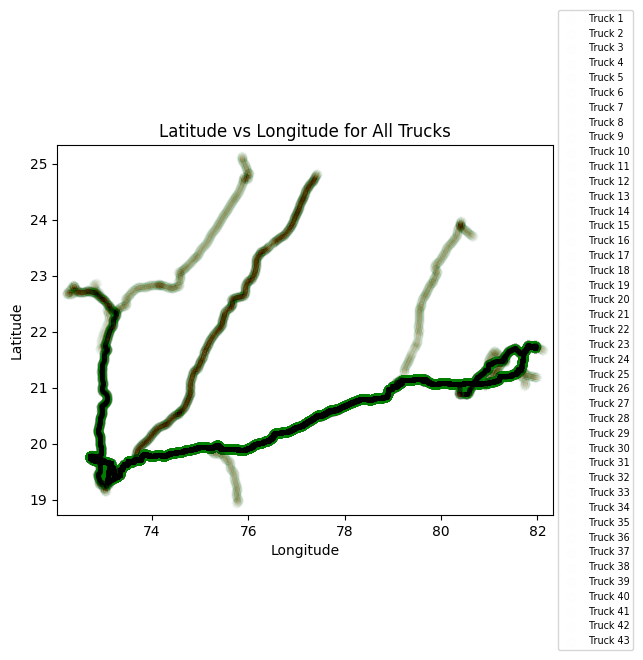

In [23]:
trucks = df['Truck'].unique()

# Create color map
cmap = cm.get_cmap('gist_rainbow', len(trucks))
# 'hsv', 'nipy_spectral', 'gist_rainbow'

# Plot each truck
for i, truck in enumerate(trucks):
    truck_data = df[df['Truck'] == truck]
    plt.scatter(
        truck_data['Longitude'],
        truck_data['Latitude'],
        label=f'Truck {truck}',
        c='g',
        alpha=0.0075
    )

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude vs Longitude for All Trucks')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),  # Push legend outside
    fontsize='x-small'
)

# Auto-adjust x and y limits
plt.xlim(df['Longitude'].min() - 0.2, df['Longitude'].max() + 0.2)
plt.ylim(df['Latitude'].min() - 0.2, df['Latitude'].max() + 0.2)

clusters = df['cluster'].unique()

# Create color map
cmap = cm.get_cmap('nipy_spectral', len(clusters))
# 'hsv', 'nipy_spectral', 'gist_rainbow'

# Plot each cluster
for i, cluster in enumerate(clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(
        cluster_data['Longitude'],
        cluster_data['Latitude'],
        marker = 's', s = 5,
        label=f'cluster {cluster}',
        c='r',
        alpha=0.005
    )

plt.show()